In [1]:
import json
import math
import os
from typing import List, Union

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
from ase import Atoms
from ase.io import iread
from ipywidgets import IntSlider, interact

from openms.lib.hippynn_es_driver import NNDriver
from openms.lib.misc import A2au, Molecule, fs2au, au2eV, eV2au
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.sh import SH

Could not import 'qutip': No module named 'qutip'


In [8]:
# trajectory taken from /projects/ml4chem/xinyang/azomethane/ml/bomd_s2/7520
xyz = """N  0.4510539073  0.2819140372  -0.3265220727
     N  -0.4422069697  -0.3284274555  0.2246181478
     C  1.8310281758  0.0518381440  0.0321861288
     C  -1.8303581429  -0.0399140770  0.0556092137
     H  2.1618227959  -0.8845481918  -0.4940810058
     H  1.9988787521  0.0074489025  1.1162364759
     H  2.4029900549  0.8707336114  -0.5216418076
     H  -2.0537011535  0.9911549930  -0.4111086677
     H  -2.2848372654  -0.1404426826  1.1142838131
     H  -2.3027538483  -0.8530699287  -0.5390258075"""
veloc = """-1.0051830544     4.7237532296     8.1514131295
    -0.4810829723    -5.8803041478    -4.5214294804
     1.2156820712    -1.0031132209    -3.7910132419
     0.4115438964     4.6371909403    -2.1871828181
    16.4340070438   -26.1365571759    19.2567674439
   -21.7786985133    29.4525856596   -24.1770348763
   -10.8219836994    -5.4896641967     6.6638899192
     4.2697814801   -22.6784903869   -15.7717243249
    22.4895607656   -16.0681027196     0.8823139464
    -9.3191499372    13.4711300432    34.1047197957"""

In [95]:
xyz = """N  0.4863978300  -0.4135297181  -0.0631457806
     N  -0.4639351703  0.3999362716  0.0506236808
     C  1.8337496290  0.1113143997  -0.0003974003
     C  -1.8692235482  -0.1130133380  0.0296797785
     H  2.1136124586  0.4790829111  -1.0517647242
     H  2.5049096656  -0.7791978700  0.2869728285
     H  2.1245711803  0.9611135378  0.6316998013
     H  -2.5033998493  0.7350320913  -0.3697314959
     H  -2.0743369629  -0.2351509611  1.0955564664
     H  -2.0794694010  -1.0321584059  -0.5643326363"""

veloc = """0.0044353679    -3.1434711211    -2.7974913962
    -4.6729513389     6.3268607666     0.5647724991
     1.9435474604     1.7609217280     1.9375770335
     3.3611927548    -1.8489621836     1.5253892002
    16.3256993647   -19.1167032527     4.3057059742
   -16.6503737817   -12.2822534784    -4.0175251023
     3.9679756362     2.8118345356    -7.4931603849
    -0.8170090336   -25.3303711750     3.3693702883
    -3.3170810286    -0.0877498837     1.5901143236
     2.1674573236    10.4729584016    -8.0744989406"""

In [101]:
# trajectory taken from /projects/ml4chem/xinyang/azomethane/ml/bomd_s2/0540
coords = """N  0.4438125250  -0.0223777944  0.3910891908
     N  -0.4666094296  0.0120538647  -0.4535860548
     C  1.8112297528  0.0426199212  -0.0534647905
     C  -1.8077199991  -0.0272232948  0.0830006692
     H  2.0544385787  0.6454701216  -0.9047155416
     H  2.2159195479  -0.9736041511  -0.0789291949
     H  2.3179885273  0.5041862494  0.8520409637
     H  -2.1976584837  -0.9844867432  -0.3066055724
     H  -2.3915173458  0.8612821277  -0.2214176982
     H  -1.8925299489  -0.1097023043  1.2371442972"""

veloc = """3.8091698578    -3.1557376073     3.3335520486
    -2.1739027218     1.8402720873    -3.5344371165
    -2.3204690468     4.0423289668    -2.2400895224
     3.3468529640    -0.5564665454    -1.2456077306
    28.0502812131     8.2794635236    13.0020213559
   -33.1034696557   -25.1229758161    25.3582462278
   -13.8636014201    -5.0172263886   -14.8502206444
    -7.6890293707     1.3314433202     2.4186939307
   -19.2293825043   -17.3810134250    10.3290978016
    10.6021177344    14.4673407799     8.4226681806"""

In [9]:
veloc = np.array(veloc.split(), dtype=float).reshape(-1, 3) * A2au / fs2au / 1000

In [5]:
def build_molecules(xyz: Union[str, List[str]], sample_veloc=False, sigma=None, **kwargs):
    if isinstance(xyz, str):
        test_molecules = Molecule(atom=xyz, **kwargs)
        # generate random velocities
        if sample_veloc:
            v = np.random.randn(*test_molecules.veloc.shape) * sigma
            test_molecules.veloc = v
    else:
        test_molecules = []
        for _ in xyz:
            mol = Molecule(atom=_, **kwargs)
            if sample_veloc:
                v = np.random.randn(*mol.veloc.shape) * sigma
                mol.veloc = v
            test_molecules.append(mol)
    return test_molecules

In [6]:
"""
basic MQC module
"""

import datetime
import math
import os
import shutil
import textwrap
from copy import copy
from typing import List, Union

import numpy as np
import torch

# This should be equivalent to the APC subroutine in NEXMD
# TODO: implement one version ourselves?
from scipy.optimize import linear_sum_assignment

import openms
from openms.lib.misc import Molecule, au2A, call_name, fs2au, typewriter
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.propagator import rk45

from openms.qmd.mqc import MQC

# TODO: this kind of definition should be part of backend
ArrayLike = Union[np.ndarray, torch.Tensor]


class SH(MQC):
    """Class for nuclear/electronic propagator used in surface hopping dynamics

    Attributes:
       :param object molecule: Molecule object

    """

    def __init__(
        self,
        molecule: List[Molecule],
        init_states: int,
        init_coef: np.array,
        qm: QuantumDriver,
        thermostat=None,
        decoherence=True,
        frustrated_hop=True,
        **kwargs,
    ):
        """Surface hopping

        :param molecule: list of molecular objects
        :type molecule: List[Molecule]
        :param init_states: initial states of each molecule
        :type init_states: np.array
        :param init_coef: initial wavefunction coefficients of each molecule
        :type init_coef: np.array
        :param qm: electronic structure driver
        :type qm: QuantumDriver
        :param thermostat: thermostat, defaults to None
        :type thermostat: object, optional
        """
        # Initialize input values
        super().__init__(molecule, init_states, init_coef, qm, thermostat, **kwargs)
        self.__dict__.update(kwargs)
        self.md_type = self.__class__.__name__
        # self.curr_ham = np.empty((len(self.mol), self.nstates, self.nstates))
        # a quick and dirty way to find the number of states
        if len(init_coef) > 30:
            self.find_hop = self._find_hop_numpy
        else:
            self.find_hop = self._find_hop_loop
        self.decoherence = decoherence
        self.frustrated_hop = frustrated_hop
        self.first_state = 1
        self.curr_coords = np.array([])
        self.curr_veloc = np.array([])
        self.sync_variables("coords")
        self.sync_variables("veloc")
        self.curr_ham = np.empty(
            (self.nstates - self.first_state, self.nstates - self.first_state),
            dtype=complex,
        )
        self.curr_time: float
        self.saved_coords: ArrayLike
        self.probability: ArrayLike

    def initialize(self, *args):
        r"""Prepare the initial conditions for both quantum and classical EOM
        It should be implemented in derived class!
        """
        # call the BaseMD.initialize for the nuclear part.
        base_dir, md_dir, qm_log_dir = super().initialize(*args)

        # initialization for electronic part (TBD)
        return base_dir, md_dir, qm_log_dir
        # return NotImplementedError("Method not implemented!")

    def sync_variables(self, var_name, forward=True):
        current = f"curr_{var_name}"
        # from self.mol[:].var_name to self.curr_{var_name}
        if forward:
            tmp = np.array([getattr(mol, var_name) for mol in self.mol])
            if hasattr(getattr(self, current), "__trunc__"):
                setattr(self, current, tmp[0])
            else:
                setattr(self, current, tmp)
        else:
            tmp = getattr(self, current)
            if hasattr(tmp, "__trunc__"):
                [setattr(mol, var_name, tmp) for mol in self.mol]
            else:
                [setattr(mol, var_name, v) for mol, v in zip(self.mol, tmp)]

    def electronic_propagator(self):
        coef = copy(self.coef)
        p = np.zeros(len(coef))
        # self.sync_variables("coords")
        self.sync_variables("veloc")
        for _ in range(self.nesteps):
            coef = self.quantum_step(self.curr_time, coef)
            density = self.get_densities(coef)
            p = self.hopping_probability(p, density)
            self.curr_time += self.edt
            self.curr_coords = self.saved_coords
        self.sync_variables("coords", forward=False)
        # print("sh", self.curr_coords)
        # e = self.qm.get_energies(self.mol[0].coords)
        # nacr = self.qm.get_nacr()
        # self.check_hops(coef, p, e, nacr)
        self.coef = coef
        self.probability = p
        # assign updated coefficients to each molecule
        # FIXME: this will only work if there is one molecule
        # for i, m in enumerate(self.mol):
        #     m.coef = coef[i]

    def quantum_step(self, t: float, coef: np.array):
        """Propagate one quantum step

        :param t: current time t
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: coefficient at time t + quantum_step
        :rtype: np.array
        """
        return rk45(self.get_coef_dot, t, coef, self.edt)

    def get_coef_dot(self, t: float, coef: np.array):
        """Calculate the acceleration for the coefficient at given Hamiltonian

        :param t: current time
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: time derivative of the coefficients at current time
        :rtype: np.array
        """
        # if saved time is different from given current time
        # the Hamiltonian needs to be recalculated
        # if t != self.curr_time:
        # FIXME: in many molecule case, this will not work.
        # self.curr_coords += self.curr_veloc * self.edt / 2
        # energies = self.qm.get_energies(self.curr_coords)
        # nact = self.qm.get_nact(self.curr_coords)
        # self.curr_ham = self.get_H(energies, nact)
        # self.curr_time = t
        # self.curr_ham = self.get_H(t)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        # FIXME: better way to pass the "temporary" coordinates to qm!
        coords = self.curr_coords.copy()
        self.curr_coords += self.curr_veloc * (t - self.curr_time)
        self.sync_variables("coords", forward=False)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        energies = self.qm.get_energies()[0]
        nact = self.qm.get_nact(self.curr_veloc)
        ham = self.get_H(energies, nact)
        c_dot = -1j * ham @ coef
        self.saved_coords = self.curr_coords
        self.curr_coords = coords
        return c_dot

    def dump_step(self):
        r"""Output coordinates, velocity, energies, electronic populations, etc.
        Universal properties will be dumped here (velocity, coordinate, energies)
        Other will be dumped in derived class!
        """

        return NotImplementedError("Method not implemented!")

    def get_H(self, energies: np.array, nact: np.array):
        """Function to assemble the Hamiltonian at the current quantum step.
        side.

        :param energies: potential energies of all excited states
        :type E: np.array
        :param nact: non-adiabatic coupling term
        :type nact: np.array
        :return: Hamiltonian of the system in matrix representation
        :rtype: np.array
        """
        ham = np.zeros_like(self.curr_ham)
        nact_cmplx = -1j * nact
        for i in range(self.first_state, len(energies)):
            # counter = 0
            idx = i - self.first_state
            ham[idx, idx] = energies[i]
        # fixme: dirty fix for one molecule only
        ham += nact_cmplx[0]
        self.curr_ham = ham
        return ham

    def get_densities(self, coef: np.array):
        # return np.einsum("i, j -> ij", np.conj(self.coef), self.coef)
        return np.outer(np.conj(coef), coef)

    def hopping_probability(self, p: np.array, density: np.array):
        j = self.current_states - self.first_state
        for n in range(self.nstates - self.first_state):
            if n != j:
                tmp = np.real(1j * density[n, j] * self.curr_ham[j, n])
                tmp *= 2 * self.edt / density[j, j].real
                # TODO: use trapezoid?
                p[n] += tmp
        return p

    def minimum_cost_solver(
        self, trans_den_mat_new: np.array, trans_den_mat_old: np.array
    ):
        """Solver to find the order of states to maximize the trace of the overlap
        matrix.

        :param trans_den_mat_new: transition density matrix at the current step
        :type trans_den_mat_new: np.array
        :param trans_den_mat_old: transition density matrix at the previous step
        :type trans_den_mat_old: np.array
        :return: order of all states at the current step
        :rtype: np.array
        """
        overlap_matrix = np.matmal(trans_den_mat_old, trans_den_mat_new.T)
        nstates = len(overlap_matrix)
        for i in range(nstates):
            for j in range(nstates):
                if j < i - 2 or j > i + 2:
                    overlap_matrix[i, j] = -1e5
        # idx will be the indices that leads to the minium cost
        _, idx = linear_sum_assignment(overlap_matrix, maximize=True)
        return idx, overlap_matrix

    def check_crossing(self, trans_den_mat_new: np.array, trans_den_mat_old: np.array):
        "check overlap for the same states before and after possible crossing"

        order = np.arange(len(trans_den_mat_new))
        cross = np.empty_like(order)
        state_idx_new, overlap = self.minimum_cost_solver(
            trans_den_mat_new, trans_den_mat_old
        )
        for i in range(len(order)):
            j = state_idx_new[i]
            if j != i:
                if i < j:
                    order[[i, j]] = order[[j, i]]
                if i < j or i == self.states:
                    if abs(overlap[i, j]) >= 0.9:
                        # trivial crossing
                        cross[i] = 2
                    else:
                        # reduce time step
                        cross[i] = 1
                else:
                    cross[i] = 0
            else:
                cross[i] = 0
        return order, cross

    def check_hops(self):
        final_state = self.find_hop(self.probability)
        # print(probability, rand)
        # no possible hop is identified
        if final_state > -1:
            final_state += self.first_state
            # print("possible hop here", self.probability, final_state)
            e = self.qm.get_energies()
            self.sync_variables("veloc")
            nacr = self.qm.get_nacr()
            (
                self.current_states,
                self.curr_veloc,
                hop_type,
            ) = self.velocity_rescaling(
                self.current_states, final_state, self.curr_veloc, e, nacr
            )
            self.sync_variables("veloc", forward=False)
            # if hop is successful, exit
            if hop_type == 1:
                # TODO: unify the variable names to use self.sync_variables
                for mol in self.mol:
                    mol.current_state = self.current_states
                # TODO: other decoherence schemes
            if self.decoherence:
                # apply instantaneous decoherence
                self.instantaneous_decoherence(self.current_states)

    def _find_hop_numpy(self, p: ArrayLike):
        """Find possible hop with operations vectorized. When the number of states is
        large (> 50), the function will be faster.

        :param p: array of hop probabilities
        :type p: np.array
        :return: final state index
        :rtype: integer
        """
        rand = self.prng.random()
        p[p < 0] = 0
        # calculate the cumulative sum of the probability array
        p_sum = np.cumsum(p)
        # return the idx if we were to insert `rand` into the array
        idx = np.searchsorted(p_sum, rand)
        # rand > sum(p), no hop
        if idx == len(p):
            return -1
        # if rand is exactly the same as the p_sum[idx], numpy will return idx
        # which is invalid for SH algorithm
        # practically, this will probably never happen
        elif rand == p_sum[idx]:
            return -1
        return idx

    def _find_hop_loop(self, p: ArrayLike):
        """Find possible hop with a loop. When the number of states is small
        (around < 30), the loop approach is likely faster than numpy.

        :param p: array of hop probabilities
        :type p: ArrayLike
        :return: final state index
        :rtype: integer
        """
        # generate random number
        rand = self.prng.random()
        # print(np.sum(p), rand)
        # manually compute cumulative sum
        cumsum = 0
        for idx, prob in enumerate(p):
            if prob <= 0:
                continue
            cumsum += prob
            if cumsum > rand:
                return idx
        return -1

    def velocity_rescaling(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
        nacr: np.array,
    ):
        """
        Updates velocity by rescaling the *momentum* in the specified direction and amount

        :param direction: the direction of the *momentum* to rescale
        :param reduction: how much kinetic energy should be damped
        """
        # normalize
        nacr = nacr[0, state_i - self.first_state, state_f - self.first_state]
        nacr = nacr / np.linalg.norm(nacr)
        inverse_mass = 1 / self.mol[0].mass
        a = np.sum(inverse_mass.reshape(-1, 1) * nacr**2)
        energies = energies[0]
        e_i = energies[state_i]
        e_f = energies[state_f]
        dE = e_f - e_i
        b = 2 * np.einsum("ij, ij", nacr, veloc[0])
        c = 2 * dE
        delta = b**2 - 4 * a * c
        # frustrated hops
        if delta < 0:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        # hops allowed
        if b < 0:
            factor = -(b + math.sqrt(delta)) / (2 * a)
        else:
            factor = -(b - math.sqrt(delta)) / (2 * a)
        veloc += factor * inverse_mass.reshape(-1, 1) * nacr
        return state_f, veloc, 1

    def instantaneous_decoherence(self, state):
        self.coef = np.zeros_like(self.coef, dtype=complex)
        self.coef[state - self.first_state] = 1 + 0j

In [7]:
class Polariton(QuantumDriver):

    def __init__(
        self,
        molecule: Union[Molecule, List[Molecule]],
        nstates: int,
        g: float,
        wc: float,
        qm: QuantumDriver,
        field=np.array([1, 0, 0])
    ):
        super().__init__()
        self.mol = molecule
        self.nstates = nstates
        self.n_pl_states = self.nstates - 1
        self.n_exc_states = self.nstates - 2
        # coupling strength
        self.g = g
        # photon frequency
        self.wc = wc
        # electronic structure without polariton
        self.qm = qm
        # electric field vector
        self.field = field
        self.h = np.zeros((self.n_pl_states, self.n_pl_states))
        self.h[0, 0] = self.wc

    def get_energies(self):
        d = self.qm.get_dipoles()
        coupling = np.dot(d[:, 1:], self.field) * self.g
        e = self.qm.get_energies()
        for i in range(1, self.n_exc_states + 1):
            self.h[i, i] = e[0, i] - e[0, 0]
        # self.h[self.n_exc_states, self.n_exc_states] = self.wc + e[0, 0]
        self.h[0, 1:] = coupling
        self.h[1:, 0] = coupling
        e_pl, c = np.linalg.eigh(self.h)
        self.c = c.T
        e = np.append(e[0, 0], e_pl + e[0, 0]).reshape(1, -1)
        self.c2 = self.c ** 2
        self.qm._assign_energies(self.mol, e)
        return e

    def calculate_forces(self):
        f = self.qm.calculate_forces()
        f = f.reshape((f.shape[1], -1))
        dmu = self.qm.get_dipole_grad().reshape(self.n_pl_states, -1)
        # dmu = self.get_dipole_grad()[1:].reshape(self.n_pl_states, -1)
        # f_pl = self.c2 @ f - self.g * dmu
        f_pl = self.c2 @ f # - 2 * self.g * self.c2 @ dmu
        for i in range(1, self.n_pl_states):
            for j in range(self.n_pl_states):
                f_pl[j] -= 2 * self.g * self.c[i, j] * self.c[0, j] * dmu[i]
        f = np.append(f[0].reshape(1, -1), f_pl, axis=0)
        f = f.reshape(1, self.nstates, -1, 3)
        self.qm._assign_forces(self.mol, f)
        return f

    def get_dipoles(self):
        d = self.qm.get_dipoles()
        d = d.reshape(d.shape[1], -1)
        d_pl = self.c.T @ d
        d = np.append(d[0].reshape(1, -1), d_pl, axis=0)
        return d

    def get_dipole_grad(self):
        dmu = self.qm.get_dipole_grad()
        dmu = dmu.reshape(dmu.shape[1], -1)
        dmu_pl = self.c.T @ dmu
        dmu = np.append(dmu[0].reshape(1, -1), dmu_pl, axis=0)
        return dmu

    def get_nacr(self):
        nacr = self.qm.get_nacr()
        shape = list(nacr.shape)
        shape[1] += 1
        shape[2] += 1
        nacr_pl = np.zeros(shape) 
        # polariton states
        for i in range(shape[1]):
            for j in range(shape[2]):
                if i == j:
                    continue
                # excited states
                tmp = 0
                for k in range(self.n_exc_states):
                    for l in range(self.n_exc_states):
                        if k == l:
                            continue
                        tmp += self.c[i, k] * self.c[j, l] * nacr[0, k, l]
                nacr_pl[0, i, j] = tmp
        return nacr_pl

    def get_nact(self, veloc: np.array):
        nacr = self.get_nacr()
        n_molecules, _, _ = veloc.shape
        veloc = veloc.reshape(n_molecules, -1)
        nacr = nacr.reshape(n_molecules, self.n_pl_states, self.n_pl_states, -1)
        nact = np.einsum("ijkl, il -> ijk", nacr, veloc)
        return nact

In [10]:
mol = [build_molecules(xyz, charge=0, nstates=5)]
mol[0].veloc = veloc.copy()
nn_es = NNDriver(
    mol,
    4,
    "test_ml/nn_models/all_states_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3_515",
    # "test_ml/nn_models/s1_new_new_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3",
    energy_conversion=1,
)
pl = Polariton(mol, 5, 0.5 / au2eV, 0.17015, nn_es)

<class 'openms.lib.misc.Molecule'> does not have attributes  mass nstates mol_type lmodel veloc ndim


In [76]:
e = pl.get_energies()

In [46]:
pl.qm.get_energies(), e

(array([[0.00309066, 0.07623421, 0.1620033 , 0.22739938]]),
 array([[0.00309066, 0.07623421, 0.1620033 , 0.17015   , 0.22739938]]))

In [77]:
e * au2eV

array([[0.08410123, 2.07443937, 4.408336  , 4.71412027, 6.18785457]])

In [80]:
pl.c

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [11]:
pl.wc * au2eV

4.630019046415001

In [12]:
e_ref = "-751.2806063774    -749.2535398321    -746.9725835704    -746.6475564199    -745.1804452985"
e_ref = np.array(e_ref.split(), dtype=float)

In [13]:
e_ref[1:] - e_ref[0]

array([2.02706655, 4.30802281, 4.63304996, 6.10016108])

In [14]:
d = """-0.637490912448138E-02   -0.307903373886540E-01    0.917101550494693E-01
 0.567889171948901       -0.807722865049390E-01    0.104096918726281
  1.02093452590826        0.282912041453332       -0.291836626155030"""
e = "-751.2806063774    -749.2535396757    -746.9623807499    -745.1875428999"
d = np.array(d.split(), dtype=float).reshape(3, 3)
e = np.array(e.split(), dtype=float)
e = (e[1:] - e[0]) / au2eV
h = np.zeros((4, 4))
h[0, 0] = 0.17015
for i in range(1, 4):
    h[i ,i] = e[i - 1]
# coupling = 0.1 * np.linalg.norm(d, axis=1)
coupling = 0.1 / au2eV * d[:, 0]
h[0, 1:] = coupling
h[1:, 0] = coupling

In [15]:
np.linalg.norm(d, axis=1) ** 2

array([0.00939944, 0.33985844, 1.20751515])

In [16]:
h

array([[ 1.70150000e-01, -2.34273504e-05,  2.08695346e-03,
         3.75186382e-03],
       [-2.34273504e-05,  7.44933003e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 2.08695346e-03,  0.00000000e+00,  1.58691807e-01,
         0.00000000e+00],
       [ 3.75186382e-03,  0.00000000e+00,  0.00000000e+00,
         2.23915872e-01]])

In [17]:
np.linalg.eigh(h)[0] 

array([0.07449329, 0.15831694, 0.170264  , 0.22417674])

In [11]:
# %%prun
# mol = [build_molecules(xyz, charge=0, nstates=5)]
# mol[0].veloc = veloc.copy()
dt = np.float64(0.1 * fs2au)
sh = SH(mol, 2, np.array([0, 1, 0, 0], dtype=complex), pl, nesteps=4, dt=dt)
e = sh.qm.get_energies()
e0 = e.reshape(-1)[0]
sh.qm.calculate_forces()
# print(sh.mol[0].states[3].forces / nn_es.energy_conversion * nn_es.coords_conversion)
# sys.exit()
coef_log = []
ham_log = []
states_log = []
coords_log = []
veloc_log = []
ekin_log = []
ener_log = []
pot_log = []

for cstep in range(500):
    # if cstep % 100 == 0:
    #     print("step ", cstep)
    print("step ", cstep)
    print("population", np.abs(sh.coef) ** 2, np.sum(np.abs(sh.coef) ** 2))
    sh.next_velocity()
    # print(sh.mol[0].coords)
    # sh.next_position()
    sh.electronic_propagator()
    # print("ass", sh.mol[0].coords)
    coords_log.append(sh.mol[0].coords.copy())

    sh.qm.get_energies()
    sh.qm.calculate_forces()
    sh.next_velocity()
    # sh.check_hops()
    veloc_log.append(sh.mol[0].veloc[0, 0])
    # print(sh.mol[0].states)
    # print("list", veloc_log[-1])
    # print("loop", sh.mol[0].veloc[0])

    if sh.thermo != None:
        sh.thermo.run(sh)

    ener_log.append(sh.mol[0].etot)
    pot_log.append(sh.mol[0].epot)
    ekin_log.append(sh.mol[0].ekin)

    sh.qstep = cstep
    coef_log.append(sh.coef)
    ham_log.append(sh.curr_ham)
    states_log.append(sh.current_states)
    # print(sh.current_states, nn_es.pred["F"], mol[0].coords)
    # angle = dihedral(sh.curr_coords[0], 2, 0, 1, 3)
    # if np.isnan(angle) or angle < 90:
    #     break

step  0
population [0. 1. 0. 0.] 1.0
step  1
population [5.28406268e-08 9.99999877e-01 3.22605257e-08 2.59522319e-09] 0.9999999645722297
step  2
population [2.06445085e-07 9.99999580e-01 1.32107028e-07 1.03320179e-08] 0.9999999291878724
step  3
population [4.37441124e-07 9.99999131e-01 3.02546497e-07 2.26196460e-08] 0.9999998938624933
step  4
population [7.06555185e-07 9.99998568e-01 5.45529283e-07 3.83090080e-08] 0.9999998586059022
step  5
population [9.66710159e-07 9.99997938e-01 8.62814158e-07 5.58598217e-08] 0.9999998234227938
step  6
population [1.17409126e-06 9.99997285e-01 1.25536451e-06 7.34569995e-08] 0.9999997883127171
step  7
population [1.30110145e-06 9.99996641e-01 1.72185880e-06 8.91550166e-08] 0.9999997532702258
step  8
population [1.34731399e-06 9.99996013e-01 2.25730572e-06 1.01110531e-07] 0.9999997182855834
step  9
population [1.34363949e-06 9.99995379e-01 2.85261021e-06 1.07877727e-07] 0.999999683346001
step  10
population [1.34693787e-06 9.99994697e-01 3.49533697e-0

Text(0.5, 0.98, 'Lower polariton')

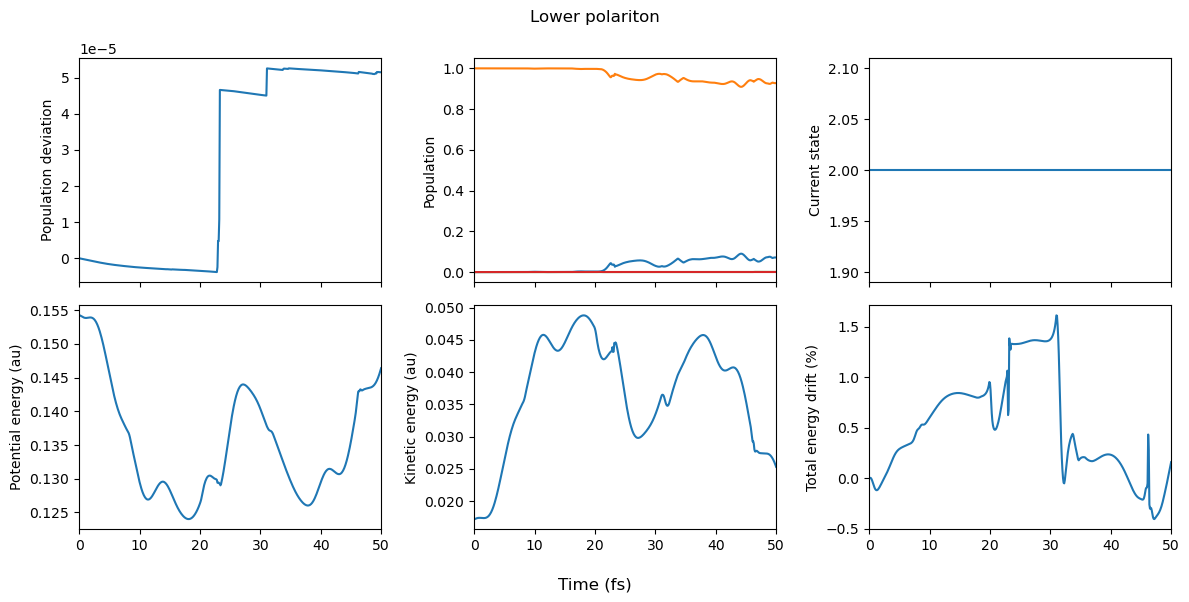

In [12]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1) - sh.first_state, axis=1
)
pop = np.abs(coef_log) ** 2
time = np.array(range(len(coef_log))) * 0.1 + 0.1

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (fs)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Population")
axs[1].plot(time, pop)
axs[2].set_ylabel("Current state")
axs[2].plot(time, states_log)
axs[3].set_ylabel("Potential energy (au)")
axs[3].plot(time, pot_log)
axs[4].set_ylabel("Kinetic energy (au)")
axs[4].plot(time, ekin_log)
axs[5].set_ylabel("Total energy drift (%)")
# axs[5].set_ylim([-0.0003, 0.0023])
axs[5].plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100)
# axs[7].plot(time, ener_log)
# for a in axs:
#     a.axvline(time[73], c='r')
fig.suptitle("Lower polariton")

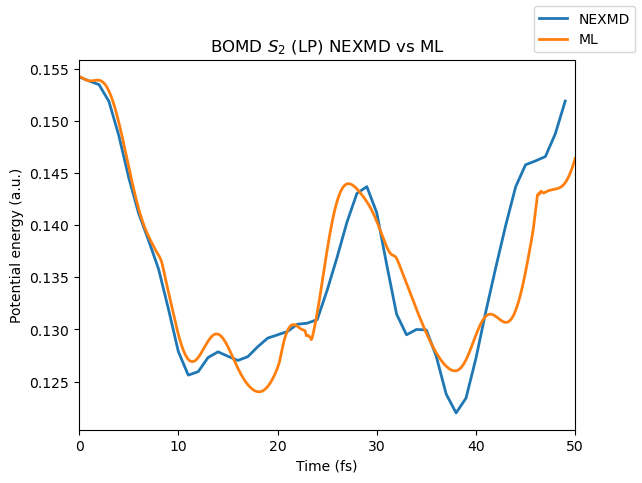

In [16]:
tmp = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s2/0540/energy-ev.out")
tmp = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s2/7520/energy-ev.out")
time_nexmd = tmp[:, 0]
ek_nexmd = tmp[:, 1] * eV2au
pot_nexmd = tmp[:, 4] * eV2au
colors = ["#e74c3c", "#f39c12", "#2980b9"]
fig, ax = plt.subplots()
ax.plot(time_nexmd, pot_nexmd - pot_nexmd[0] + pot_log[0], label=f"NEXMD", lw=2)
ax.plot(time, pot_log, label="ML", lw=2)
ax.set_xlim(0, 50)
plt.title("BOMD $S_2$ (LP) NEXMD vs ML")
ax.set_ylabel("Potential energy (a.u.)")
ax.set_xlabel("Time (fs)")
# ax2 = ax.twinx()
# ax2.set_ylabel("Total energy drift (%)")
# ax2.plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100, ls=":", c="k", label="Total energy drift")
fig.legend()

Text(0.5, 1.0, 'BOMD UP ($S_3$)')

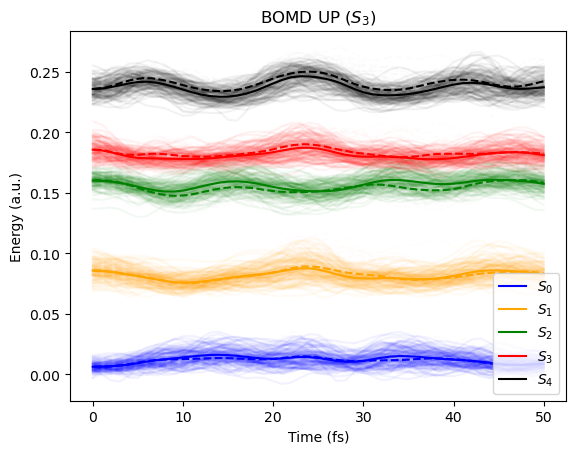

In [3]:
nstates = 5
nsteps_ml = 500
fig, ax = plt.subplots()
colors = ["blue", "orange", "green", "red", "black"]
time = np.arange(1, nsteps_ml + 1) * 0.1
e0 = []
pes_ml = np.zeros((nsteps_ml, nstates))
count = np.zeros(nsteps_ml)
dirs = os.listdir("test_ml/results_bomd_pl_s3")
for i in dirs:
    dir = f"test_ml/results_bomd_pl_s3/{i}"
    pes = np.genfromtxt(f"{dir}/epot.txt")
    total_steps = len(pes)
    for j in range(nstates):
        ax.plot(time[:len(pes)], pes[:, j], c=colors[j], ls="--", alpha=0.01)
    pes_ml[:total_steps] += pes
    e0.append(pes[0, 0])
    count[:total_steps] += 1
pes_ml /= count.reshape(-1, 1)
e0 = np.array(e0)
pes_nexmd = np.zeros((nsteps_ml // 10 + 1, nstates + 1))
count = np.zeros(nsteps_ml // 10 + 1)
dirs = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s3/123", dtype=str)
for j, i in enumerate(dirs):
    dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s3/{i}"
    pes = np.genfromtxt(f"{dir}/pes.out")
    total_steps = len(pes)
    pes[:, 1:] *= eV2au
    pes[:, 1:] -= pes[1, 1] - e0[j]
    for i in range(nstates):
        ax.plot(pes[:, 0], pes[:, i + 1], c=colors[i], alpha=0.05)
    pes_nexmd[:total_steps] += pes
    count[:total_steps] += 1
pes_nexmd /= count.reshape(-1, 1)
for i in range(nstates):
    ax.plot(time, pes_ml[:, i], c=colors[i], ls="--")
    ax.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i], label=f"$S_{i}$")
ax.legend()
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Energy (a.u.)")
ax.set_title("BOMD UP ($S_3$)")

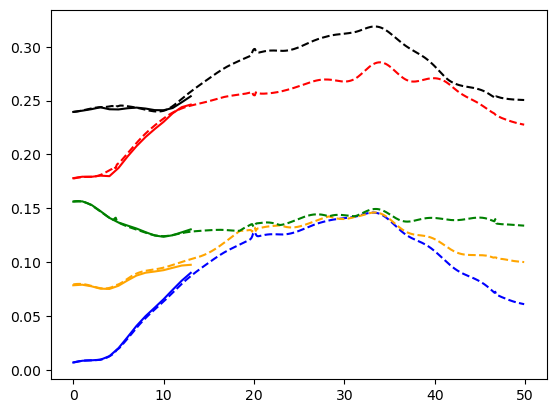

In [32]:
colors = ["blue", "orange", "green", "red", "black"]
pes_ml = np.genfromtxt("test_ml/results_bomd_pl_s2/5/epot.txt")
pes_nexmd = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s2/0100/pes.out")
pes_nexmd[:, 1:] *= eV2au
pes_nexmd[:, 1:] -= pes_nexmd[0, 1] - pes_ml[0, 0]
for i in range(5):
    plt.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i])
    plt.plot(np.arange(len(pes_ml)) * 0.1, pes_ml[:, i], ls="--", c=colors[i])